---
title: 2.1 线性回归
date: 2024-2-3 14:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---
#  
<!--more-->
# 1. 线性回归
## 1.1 线性回归的基本元素
- 基于几个简单的假设：
    - 假设自变量x和因变量y之间的关系是线性的
    - 假设y的观测值是通过均值为0的噪声扰动后得到的
- 一些概念：
    - 训练集：训练模型的数据集
    - 样本：每行数据
    - 标签：试图预测的值
    - 特征（feature，协变量（covariate））：预测所依赖的输入变量
### 1.1.1 线性模型
$$\hat y = w_1x1+w_2x_2+b \rightarrow \hat y = \mathbf{w}^T\mathbf{x}+b$$
- $w_1$和$w_2$是权重
- $b$是偏置(bias),也叫偏移量(offset),截距(intercept)：当所有特征都取值为0时，预测值应该为多少。
- 严格来说，上述公式是输入特征的一个 仿射变换（affine transformation）：仿射变换的特点是通过加权和对特征进行线性变换（linear transformation），并通过偏置项来进行平移（translation）。
- 对于整个数据集，特征集合是一个矩阵：$\hat y = \mathbf{X}\mathbf{w}+b$
### 1.1.2 损失函数
- 量化目标的实际值与预测值之间的差距。
- 回归问题中最常用的损失函数是平方误差函数:
    - $l^{(i)}(\mathbf{w},b) = \frac{1}{2}(\hat y^{(i)}-y^{(i)})^2$
- 训练目标：寻找一组参数（$\mathbf{w^*},b^*$）,使得所有样本的损失函数之和最小：
$$\mathbf{w^*},b^* = L(\mathbf{w},b) \underset{\mathbf{w},b}{\arg\min} \frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w},b)$$
### 1.1.3 解析解
$$\mathbf{w^*} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$
### 1.1.4 随机梯度下降
- $$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|}\sum_{i\in\mathcal{B}}\partial_{(\mathbf{w},b)}l^{(i)}(\mathbf{w},b)$$
- 通过不断地在损失函数递减的方向上更新参数来降低误差。
- 梯度下降最简单的用法是计算损失函数（数据集中所有样本的损失均值）关于模型参数的导数（在这里也可以称为梯度）。但实际中的执行可能会非常慢：因为在每一次更新参数之前，我们必须遍历整个数据集。因此，我们通常会在每次需要计算更新的时候随机抽取一小批样本$\mathcal{B}$，并计算损失函数关于这些样本的平均损失的梯度。
- 算法过程：
    - 1）初始化模型参数的值，如随机初始化
    - 2）从数据集中随机抽取一小批样本且在负梯度方向上更新参数
    - 3）重复步骤2直到收敛
    - 例如对于平方损失和放射变换：
        - $\mathbf{w} \leftarrow \mathbf{w} - \frac{\eta}{|\mathcal{B}|}\sum\limits_{i\in\mathcal{B}}\mathbf{x}^{(i)}(\mathbf{w}^T\mathbf{x}^{(i)}+b-y^{(i)})$
        - $b \leftarrow b - \frac{\eta}{|\mathcal{B}|}\sum\limits_{i\in\mathcal{B}}(\mathbf{w}^T\mathbf{x}^{(i)}+b-y^{(i)})$
            - $\eta$是学习率
            - $\mathcal{B}$是小批量样本的大小(batch size)
    - 对像深度神经网络这样复杂的模型来说，损失平面上通常包含多个最小值。深度学习实践者很少会去花费大力气寻找这样一组参数，使得在训练集上的损失达到最小。事实上，更难做到的是找到一组参数，这组参数能够在我们从未见过的数据上实现较低的损失，这一挑战被称为泛化（generalization）。
### 1.1.5 用模型进行预测
$$\hat y = \mathbf{\hat w}^T\mathbf{x}+\hat b$$
## 1.2 矢量化加速
- 在训练我们的模型时，我们经常希望能够同时处理整个小批量的样本。而不是在Python中编写开销高昂的for循环。



In [2]:
import math
import time
import numpy as np
import torch
from d2l import torch as d2l
#计时器
class Timer: #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [3]:
#1 两个10000维向量
n = 10000
a = torch.ones(n)
b = torch.ones(n)
c = torch.zeros(n)

#2 for循环计算
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
print(f'{timer.stop():.5f} sec')

#3 一次性计算
timer.start()
d = a + b
print(f'{timer.stop():.7f} sec')

0.11051 sec
0.0000000 sec


## 1.3 正态分布与平方损失
- 正态分布（高斯分布）：
$$p(x) = \frac{1}{\sqrt{2\pi\sigma^2}}exp(-\frac{(x-\mu)^2}{2\sigma^2})$$

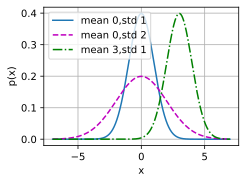

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
#1 定义一个函数来计算高斯分布
def normal(x,mu,sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

#2 可视化高斯分布
x = np.arange(-7,7,0.01)
#均值和标准差对
params = [(0,1),(0,2),(3,1)]
d2l.plot(x,[normal(x,mu,sigma) for mu,sigma in params],xlabel='x',ylabel='p(x)',legend=[f'mean {mu},std {sigma}' for mu,sigma in params])

- 假设观测中包含噪声：$$y = \mathbf{w}^T\mathbf{x}+b+\epsilon$$
    - 噪声$\epsilon \sim N(0,\sigma^2)$
    - 因此有：(y服从正态分布，y的均值是$\mathbf{w}^T\mathbf{x}+b$，方差是$\sigma^2$)
        - 1）通过给定的$\mathbf{x}$观测到特定y的似然（likelihood）：$$p(y|\mathbf{x}) = \frac{1}{\sqrt{2\pi\sigma^2}}exp(-\frac{(y-\mathbf{w}^T\mathbf{x}-b)^2}{2\sigma^2})$$
        - 2）根据极大似然估计，参数（$\mathbf{w},b$）的最优值使整个数据集的似然最大：$$p(\mathbf{y}|\mathbf{X}) = \prod \limits_{i=1}^n p(y^{(i)}|\mathbf{x}^{(i)})$$
        - 3）根据极大似然估计法选择的估计量称为极大似然估计量。虽然使许多指数函数的乘积最大化看起来很困难，但是我们可以在不改变目标的前提下，通过最大化似然对数来简化：$$-log P(\mathbf{y}|\mathbf{X}) = \frac{n}{2}log(2\pi\sigma^2)+\frac{1}{2\sigma^2}\sum \limits_{i=1}^n(y^{(i)}-\mathbf{w}^T\mathbf{x}^{(i)}-b)^2$$
        - 4）假设$\sigma$是常数，则可以忽略第一项；第二项除了常数项$\frac{1}{\sigma^2}$之外，就是平方损失函数。因此，在高斯噪声的假设下，最小化均方误差等价于对线性模型的极大似然估计。

## 1.4 从线性回归到深度网络
### 1.4.1 神经网络
- 线性回归是一个单层神经网络（隐去了权重和偏置）：
- 每个输入都与每个输出相连，成为全连接层（fully connected layer）或稠密层（dense layer）。
![](1_linear_regression_files/1.png)
